## Titanic Project Overview

**Goal**

It is your job to predict if a passenger survived the sinking of the Titanic or not. 
For each in the test set, you must predict a 0 or 1 value for the variable.

**Metric**

Your score is the percentage of passengers you correctly predict. This is known as accuracy.

**TODO**

1) Understand the shape of the data (Histograms, box plots, etc.)

2) Data Cleaning

3) Data Exploration

4) Feature Engineering

5) Data Preprocessing for Model

6) Basic Model Building

7) Model Tuning

8) Ensemble Modle Building

9) Results

In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns 
import matplotlib.pyplot as plt

%matplotlib inline

In [3]:
# training = pd.read_csv('/kaggle/input/titanic/train.csv')
# test = pd.read_csv('/kaggle/input/titanic/test.csv')

training = pd.read_csv('input/train.csv')
test = pd.read_csv('input/test.csv')

training['train_test'] = 1
test['train_test'] = 0
test['Survived'] = np.NaN
all_data = pd.concat([training,test])

all_data.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked', 'train_test'],
      dtype='object')

### Project Planning
* Understand nature of the data .info() .describe()
* Histograms (for numeric) and boxplots (for categorical)
* Value counts 
* Missing data 
* Correlation between the metrics 
* Explore interesting themes 
    * Wealthy survive? 
    * By location 
    * Age scatterplot with ticket price 
    * Young and wealthy Variable? 
    * Total spent? 
* Feature engineering 
* Preprocess data together or use a transformer? 
    * Use label for train and test   
* Scaling?
* **Model Baseline** 
* Model comparison with CV 

### Light Data Exploration

* For numeric data
    - Made histograms to understand distributions
    - Corrplot
    - Pivot table comparing survival rate across numeric variables 
* For categorical data
    - Made bar charts to understand balance of classes
    - Made pivot tables to understand relationship with survival


In [4]:
# quick look at our data types & null counts 
training.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
 12  train_test   891 non-null    int64  
dtypes: float64(2), int64(6), object(5)
memory usage: 90.6+ KB


In [5]:
training.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
train_test       0
dtype: int64

In [6]:
# to better understand the numeric data, we want to use the .describe() method. This gives us an understanding of the central tendencies of the data 
training.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare,train_test
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000,891.0
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208,1.0
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429,0.0
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000,1.0
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400,1.0
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200,1.0
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000,1.0
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200,1.0


In [7]:
# quick way to separate numeric columns
training.describe().columns

Index(['PassengerId', 'Survived', 'Pclass', 'Age', 'SibSp', 'Parch', 'Fare',
       'train_test'],
      dtype='object')

In [8]:
# look at numeric and categorical values separately 
df_num = training[['Age','SibSp','Parch','Fare']]
df_cat = training[['Survived','Pclass','Sex','Ticket','Cabin','Embarked']]

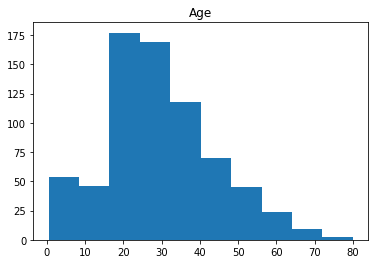

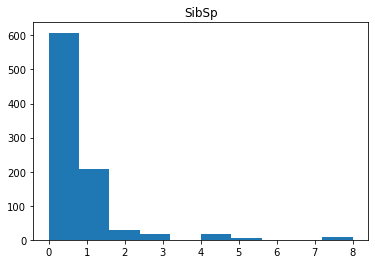

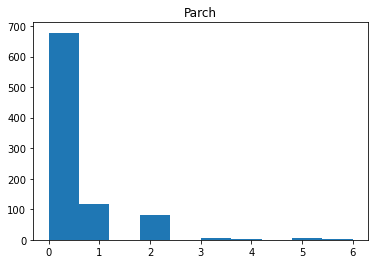

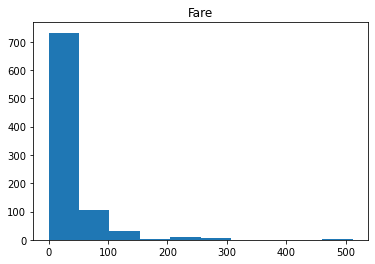

In [9]:
# distributions for all numeric variables 
for i in df_num.columns:
    plt.hist(df_num[i])
    plt.title(i)
    plt.show()

We have to scale the variables before fitting into the model.

            Age     SibSp     Parch      Fare
Age    1.000000 -0.308247 -0.189119  0.096067
SibSp -0.308247  1.000000  0.414838  0.159651
Parch -0.189119  0.414838  1.000000  0.216225
Fare   0.096067  0.159651  0.216225  1.000000


<AxesSubplot:>

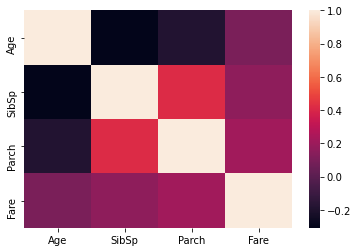

In [12]:
# looking at the correlations
print(df_num.corr())
sns.heatmap(df_num.corr())

In [17]:
all_data_corr = all_data.corr().abs().unstack().sort_values(kind="quicksort", ascending=False).reset_index()
all_data_corr.rename(columns={"level_0": "Feature 1", "level_1": "Feature 2", 0: 'Correlation Coefficient'}, inplace=True)
all_data_corr.drop(all_data_corr.iloc[1::2].index, inplace=True)
all_data_corr_nd = all_data_corr.drop(all_data_corr[all_data_corr['Correlation Coefficient'] == 1.0].index)

corr = all_data_corr_nd['Correlation Coefficient'] > 0.1
all_data_corr_nd[corr]

,Feature 1,Feature 2,Correlation Coefficient
8,PassengerId,train_test,0.807510
10,Fare,Pclass,0.558629
12,Pclass,Age,0.408106
14,Parch,SibSp,0.373587
16,Pclass,Survived,0.338481
18,Fare,Survived,0.257307
20,SibSp,Age,0.243699
22,Parch,Fare,0.221539
24,Fare,Age,0.178740
26,SibSp,Fare,0.160238


In [19]:
# compare survival rate across Age, SibSp, Parch, and Fare 
pd.pivot_table(training, index='Survived', values=['Age','SibSp','Parch','Fare'])

,Age,Fare,Parch,SibSp
Survived,,,,
0,30.626179,22.117887,0.329690,0.553734
1,28.343690,48.395408,0.464912,0.473684


In [27]:
# pivot_table and groupby is almost the same
training.groupby(['Survived']).mean()[['Age','SibSp','Parch','Fare']] 

,Age,SibSp,Parch,Fare
Survived,,,,
0,30.626179,0.553734,0.329690,22.117887
1,28.343690,0.473684,0.464912,48.395408


We can see that the if you were younger, had not siblings and parents, and payed higher fare, meaning that you were in 1st class, then you had higher chance for survival.

/opt/homebrew/Caskroom/miniforge/base/envs/tf/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


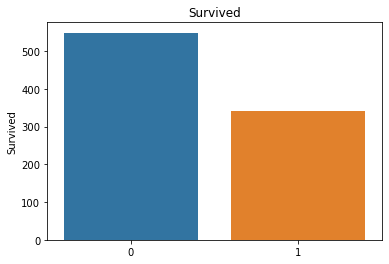

/opt/homebrew/Caskroom/miniforge/base/envs/tf/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


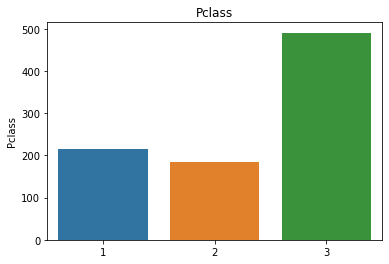

/opt/homebrew/Caskroom/miniforge/base/envs/tf/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


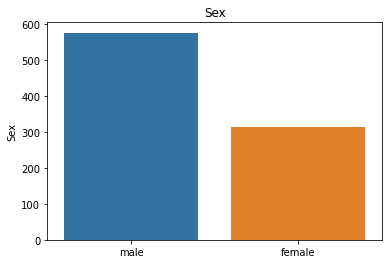

/opt/homebrew/Caskroom/miniforge/base/envs/tf/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


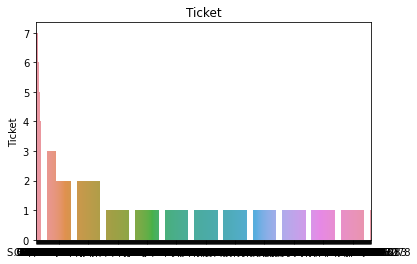

/opt/homebrew/Caskroom/miniforge/base/envs/tf/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


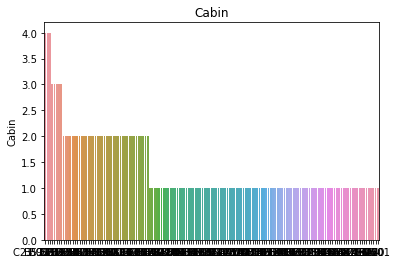

/opt/homebrew/Caskroom/miniforge/base/envs/tf/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


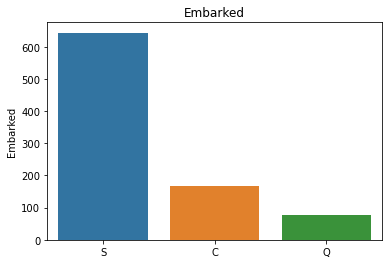

In [32]:
for i in df_cat.columns:
    sns.barplot(df_cat[i].value_counts().index, df_cat[i].value_counts()).set_title(i)
    plt.show()

Cabin and ticket graphs are very messy. This is an area where we may want to do some feature engineering!

In [37]:
# Comparing survival and each of these categorical variables 
print(pd.pivot_table(training, index='Survived', columns='Pclass', values='Ticket', aggfunc='count'))
print()
print(pd.pivot_table(training, index='Survived', columns='Sex', values='Ticket', aggfunc='count'))
print()
print(pd.pivot_table(training, index='Survived', columns='Embarked', values='Ticket', aggfunc='count'))

Pclass      1   2    3
Survived              
0          80  97  372
1         136  87  119

Sex       female  male
Survived              
0             81   468
1            233   109

Embarked   C   Q    S
Survived             
0         75  47  427
1         93  30  217


### Feature Engineering

1) Cabin - Simplify cabins (evaluated if cabin letter (cabin_adv) or the purchase of tickets across multiple cabins (cabin_multiple) impacted survival)

2) Tickets - Do different ticket types impact survival rates?

3) Does a person's title relate to survival rates?

In [39]:
df_cat.Cabin.isnull().sum() # 687 null values

687

In [40]:
training['cabin_multiple'] = training.Cabin.apply(lambda x: 0 if pd.isna(x) else len(x.split(' ')))
# after looking at this, we may want to look at cabin by letter or by number. Let's create some categories for this 
# letters 
# multiple letters 
training['cabin_multiple'].value_counts()

0    687
1    180
2     16
3      6
4      2
Name: cabin_multiple, dtype: int64

In [48]:
pd.pivot_table(training, index='Survived', columns='cabin_multiple', values='Ticket', aggfunc='count')

cabin_multiple,0,1,2,3,4
Survived,,,,,
0,481.0,58.0,7.0,3.0,NaN
1,206.0,122.0,9.0,3.0,2.0


In [50]:
# creates categories based on the cabin letter (n stands for null)
# in this case we will treat null values like it's own category

training['cabin_adv'] = training.Cabin.apply(lambda x: str(x)[0])
training['cabin_adv']

0      n
1      C
2      n
3      C
4      n
      ..
886    n
887    B
888    n
889    C
890    n
Name: cabin_adv, Length: 891, dtype: object

In [52]:
# comparing surivial rate by cabin
print(training.cabin_adv.value_counts())
pd.pivot_table(training, index='Survived', columns='cabin_adv', values='Ticket', aggfunc='count')

n    687
C     59
B     47
D     33
E     32
A     15
F     13
G      4
T      1
Name: cabin_adv, dtype: int64


cabin_adv,A,B,C,D,E,F,G,T,n
Survived,,,,,,,,,
0,8.0,12.0,24.0,8.0,8.0,5.0,2.0,1.0,481.0
1,7.0,35.0,35.0,25.0,24.0,8.0,2.0,NaN,206.0


Now, working with Ticket feature

In [53]:
training.Ticket

0             A/5 21171
1              PC 17599
2      STON/O2. 3101282
3                113803
4                373450
             ...       
886              211536
887              112053
888          W./C. 6607
889              111369
890              370376
Name: Ticket, Length: 891, dtype: object

In [55]:
# understand ticket values better 
# numeric vs non numeric 
training['numeric_ticket'] = training.Ticket.apply(lambda x: 1 if x.isnumeric() else 0)
training['ticket_letters'] = training.Ticket.apply(lambda x: ''.join(x.split(' ')[:-1]).replace('.','').replace('/','').lower() if len(x.split(' ')[:-1]) > 0 else 0)

training['numeric_ticket'].value_counts()

1    661
0    230
Name: numeric_ticket, dtype: int64

In [56]:
# pd.set_option("max_rows", None)
training['ticket_letters'].value_counts()

0            665
pc            60
ca            41
a5            21
stono2        18
sotonoq       15
scparis       11
wc            10
a4             7
soc            6
c              5
fcc            5
wep            3
sopp           3
pp             3
swpp           2
ppp            2
sotono2        2
scah           2
casoton        1
as             1
scow           1
fa             1
fc             1
sp             1
sop            1
sca4           1
scahbasle      1
sc             1
Name: ticket_letters, dtype: int64

In [57]:
# difference in numeric vs non-numeric tickets in survival rate 
pd.pivot_table(training, index='Survived', columns='numeric_ticket', values='Ticket', aggfunc='count')

numeric_ticket,0,1
Survived,,
0,142,407
1,88,254


In [58]:
# survival rate across different ticket types 
pd.pivot_table(training, index='Survived', columns='ticket_letters', values='Ticket', aggfunc='count')

ticket_letters,0,a4,a5,as,c,ca,casoton,fa,fc,fcc,...,soc,sop,sopp,sotono2,sotonoq,sp,stono2,swpp,wc,wep
Survived,,,,,,,,,,,,,,,,,,,,,
0,410.0,7.0,19.0,1.0,3.0,27.0,1.0,1.0,1.0,1.0,...,5.0,1.0,3.0,2.0,13.0,1.0,10.0,NaN,9.0,2.0
1,255.0,NaN,2.0,NaN,2.0,14.0,NaN,NaN,NaN,4.0,...,1.0,NaN,NaN,NaN,2.0,NaN,8.0,2.0,1.0,1.0


Now, working with **Name** feature

In [61]:
# feature engineering on person's title 
training.Name.head(50)
training['name_title'] = training.Name.apply(lambda x: x.split(',')[1].split('.')[0].strip())
# mr., ms., master. etc

training['name_title'].value_counts()

Mr              517
Miss            182
Mrs             125
Master           40
Dr                7
Rev               6
Mlle              2
Major             2
Col               2
the Countess      1
Jonkheer          1
Lady              1
Ms                1
Capt              1
Sir               1
Mme               1
Don               1
Name: name_title, dtype: int64